## Import

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import os
import numpy as np
import random
import warnings
import dataset as d
warnings.filterwarnings(action='ignore') 

## Hyperparameter Settings

In [2]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10, #Your Epochs,
    'LR':1e-5, #Your Learning Rate,
    'BATCH_SIZE': 128, #Your Batch Size,
    'SEED':41
}

## Fixed Random-Seed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Custom Dataset

In [5]:
# dataset.py 의 CustomDataset 클래스 사용
import dataset as d
from util.preprocessing import  *


In [6]:
img = Image.open("data/open/train/00alrvto9c.jpg").convert('RGB').numpy()

AttributeError: numpy

## Define Model

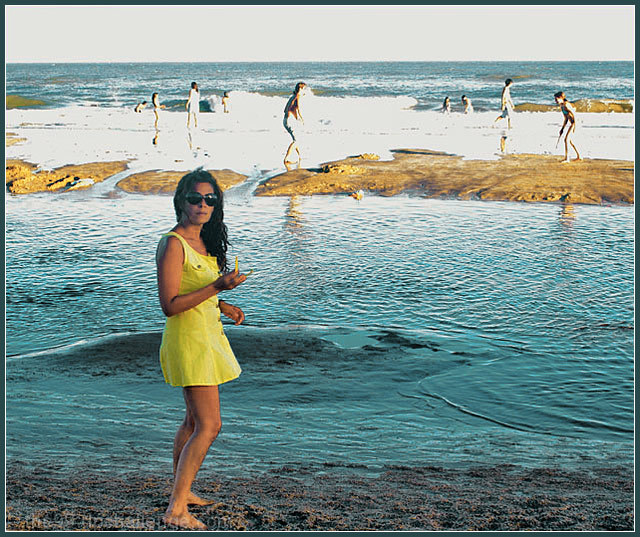

In [5]:
img

## Train

In [10]:
# 데이터 로드
train_data = pd.read_csv('./data/open/train.csv')

# 단어 사전 생성
all_comments = ' '.join(train_data['comments']).split()
vocab = set(all_comments)
vocab = ['<PAD>', '<SOS>', '<EOS>'] + list(vocab)
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

# 데이터셋 및 DataLoader 생성
transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])), 
    transforms.ToTensor()
])
train_dataset = d.CustomDataset(train_data, transform)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

# 모델, 손실함수, 옵티마이저
model = encoder.EncoderCNN(len(vocab))
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])

# 학습
model.train()
for epoch in range(CFG['EPOCHS']):
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for imgs, comments in loop:
        imgs = imgs.float()
        
        # Batch Preprocessing
        comments_tensor = torch.zeros((len(comments), len(max(comments, key=len)))).long()
        for i, comment in enumerate(comments):
            tokenized = ['<SOS>'] + comment.split() + ['<EOS>']
            comments_tensor[i, :len(tokenized)] = torch.tensor([word2idx[word] for word in tokenized])
            print(comments_tensor.size())
            
        # Forward & Loss
        predicted_comments = model(imgs, comments_tensor)
        loss = criterion(predicted_comments.view(-1, len(vocab)), comments_tensor.view(-1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1} finished with average loss: {total_loss / len(train_loader):.4f}")

  0%|          | 1/583 [00:00<07:21,  1.32it/s]

torch.Size([128, 290])


  0%|          | 2/583 [00:01<06:59,  1.39it/s]

torch.Size([128, 225])


  1%|          | 3/583 [00:02<06:50,  1.41it/s]

torch.Size([128, 223])


  1%|          | 4/583 [00:02<06:46,  1.43it/s]

torch.Size([128, 245])


  1%|          | 5/583 [00:03<06:56,  1.39it/s]

torch.Size([128, 174])


  1%|          | 6/583 [00:04<06:51,  1.40it/s]

torch.Size([128, 185])


  1%|          | 6/583 [00:04<07:23,  1.30it/s]


KeyboardInterrupt: 

## Inference & Submit

In [ ]:
test_data = pd.read_csv('./data/open/test.csv')
test_dataset = d.CustomDataset(test_data, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predicted_mos_list = []
predicted_comments_list = []

def greedy_decode(model, image, max_length=50):
    image = image.unsqueeze(0)
    mos, _ = model(image)
    output_sentence = []
    
    # 시작 토큰 설정
    current_token = torch.tensor([word2idx['<SOS>']])
    hidden = None
    features = model.cnn(image).view(image.size(0), -1)

    for _ in range(max_length):
        embeddings = model.embedding(current_token).unsqueeze(0)
        combined = torch.cat([features.unsqueeze(1), embeddings], dim=2)
        out, hidden = model.lstm(combined, hidden)
        
        output = model.fc(out.squeeze(0))
        _, current_token = torch.max(output, dim=1)

        # <EOS> 토큰에 도달하면 멈춤
        if current_token.item() == word2idx['<EOS>']:
            break

        # <SOS> 또는 <PAD> 토큰은 생성한 캡션에 추가하지 않음
        if current_token.item() not in [word2idx['<SOS>'], word2idx['<PAD>']]:
            output_sentence.append(idx2word[current_token.item()])
     
    return mos.item(), ' '.join(output_sentence)

# 추론 과정
with torch.no_grad():
    for imgs, _, _ in tqdm(test_loader):
        for img in imgs:
            img = img.float()
            mos, caption = greedy_decode(model, img)
            predicted_mos_list.append(mos)
            predicted_comments_list.append(caption)

# 결과 저장
result_df = pd.DataFrame({
    'img_name': test_data['img_name'],
    'mos': predicted_mos_list,
    'comments': predicted_comments_list  # 캡션 부분은 위에서 생성한 것을 사용
})

# 예측 결과에 NaN이 있다면, 제출 시 오류가 발생하므로 후처리 진행 (sample_submission.csv과 동일하게)
result_df['comments'] = result_df['comments'].fillna('Nice Image.')
result_df.to_csv('submit.csv', index=False)

print("Inference completed and results saved to submit.csv.")